In [7]:
import pandas as pd
print("pandas version: {}". format(pd.__version__))

import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, train_test_split, cross_val_score, learning_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score
print("sklearn version: {}". format(sklearn.__version__))

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.simplefilter('ignore')

pandas version: 1.4.3
numpy version: 1.21.5
sklearn version: 1.1.1


In [20]:
def load_data():
    # load prepared training and test dataset
    df_train = pd.read_pickle('../03_dataCleaningPreparation/df_train_prepared_reduced.pkl')
    df_test = pd.read_pickle('../03_dataCleaningPreparation/df_test_prepared_reduced.pkl')

    # split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
    y_train = df_train['Survived']
    x_train = df_train.drop(['Survived'], axis=1)
    x_test = df_test

    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.3, stratify = y_train, random_state = 42)

    return x_train, y_train, x_validate, y_validate, x_test

x_train, y_train, x_validate, y_validate, x_test = load_data()

In [17]:
x_train.shape

(623, 21)

In [11]:
def evaluate_model(x_train, y_train, y_validate, y_validate_pred, y_validate_scores, pipeline):
    """
    evaluate the classification model with
    - classification report
    - precision-recall-curve
    - ROC curve
    """

    def plot_learning_curve(pipeline, x_train, y_train):

        train_sizes, train_scores, test_scores = learning_curve(
            pipeline,
            x_train,
            y_train,
            cv=5,
            n_jobs=-1,
            train_sizes=np.linspace(.1, 1.0, 8)
            )


        fig1, ax1 = plt.subplots()
        ax1.set_xlabel("Training examples")
        ax1.set_ylabel("Score")
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.grid()

        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

        ax1.legend(loc="best")
        ax1.set_title("Difference between training and CV: "\
            + str(round(test_scores_mean[7] / train_scores_mean[7] * 100, 2))\
            + "%")
        plt.show()


    def plot_confusion_matrix(y_validate, y_validate_pred):
        group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in
                        confusion_matrix(y_validate, y_validate_pred).flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             confusion_matrix(y_validate, y_validate_pred).flatten()/np.sum(confusion_matrix(y_validate, y_validate_pred))]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        fig2, ax2 = plt.subplots()
        sns.heatmap(confusion_matrix(y_validate, y_validate_pred), annot=labels, fmt="", cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


    def plot_precision_recall_vs_threshold(y_validate, y_scores):
        precisions, recalls, thresholds = precision_recall_curve(y_validate, y_scores)

        # convert to f score
        fscore = (2 * precisions * recalls) / (precisions + recalls)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        

        fig3, ax3 = plt.subplots()
        ax3.plot(thresholds, precisions[:-1], "b", label="Precision")
        ax3.plot(thresholds, recalls[:-1], "g", label="Recall")
        ax3.plot(thresholds, fscore[:-1], "r", label="F1 Score")
        ax3.axvline(x=thresholds[ix], color='red', linestyle='--')
        plt.axhline(y=precisions[ix], color='b', linestyle='--')
        plt.axhline(y=recalls[ix], color='g', linestyle='--')
        ax3.set_xlabel("Threshold")
        ax3.legend(loc="upper left")
        ax3.set_ylim([0,1])
        plt.show()

        fig4, ax4 = plt.subplots()
        ax4.plot(recalls, precisions, marker='.', label='Logistic')
        ax4.scatter(recalls[ix], precisions[ix], 200, marker='o', color='red', label='Best')
        ax4.set_xlabel('Recall')
        ax4.set_ylabel('Precision')
        plt.show()
        

    def plot_roc_curve(y_validate, y_scores):
        fpr, tpr, thresholds = roc_curve(y_validate, y_scores)

        roc_auc = round(roc_auc_score(y_validate, y_scores), 3)
        
        optimal_idx = np.argmax(tpr - fpr)

        fig5, ax5 = plt.subplots()
        ax5.plot(fpr, tpr, linewidth=2)
        ax5.plot([0,1], [0,1], 'k--')
        ax5.axis([0,1,0,1])
        ax5.scatter(fpr[optimal_idx], tpr[optimal_idx], 200, marker='o', color='red', label='Best')
        ax5.set_xlabel('False Positive Rate')
        ax5.set_ylabel('True Positive Rate')
        plt.show()


        

    plot_confusion_matrix(y_validate, y_validate_pred)
    plot_precision_recall_vs_threshold(y_validate, y_validate_scores)
    plot_roc_curve(y_validate, y_validate_scores)
    plot_learning_curve(pipeline, x_train, y_train)

In [3]:
# only scale the features that are not one-hot-encoded [0,1]
transformer_num = [
    "Pclass",
    "Parch",
    "Family",
    "TNlen",
    "LeadingDigit",
    "Fare_bin",
    "Age_bin",
    ]



# define cross validation
cv = ShuffleSplit(
    n_splits = 5,
    test_size = 0.3,
    train_size = 0.7,
    random_state = 42
    )

In [4]:
col_transform = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), transformer_num)
    ], remainder='passthrough'
)


parameters = {
    'kernel':('linear', 'rbf'),
    'C':[1, 10]
}


model = RandomForestClassifier(n_jobs=-1)



In [21]:
pipeline = Pipeline(steps=[
    ('columnprep', col_transform),
    ('algo', model)
])

clf = GridSearchCV(pipeline, parameters)

score = cross_val_score(
            pipeline,
            x_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        ).mean()

print(score)

0.8256684491978611


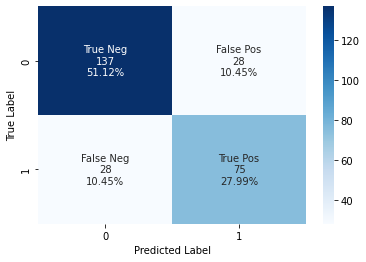

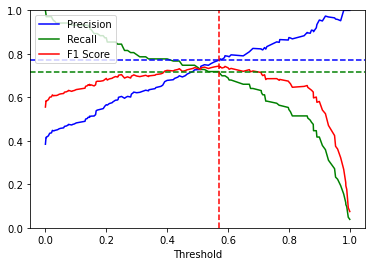

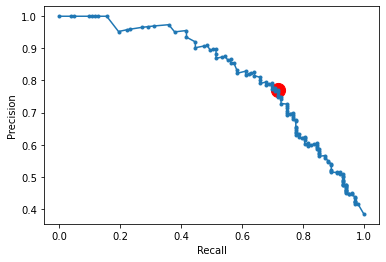

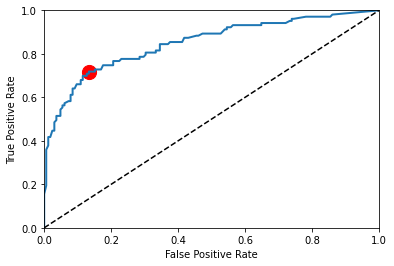

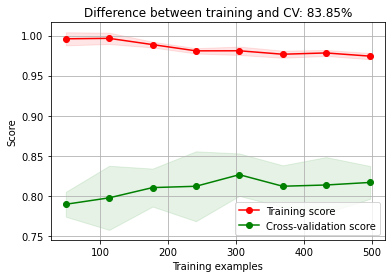

In [19]:
# fit the pipeline to compute the validation results
pipeline.fit(x_train, y_train)

# predict the training outcome
y_validate_pred = pipeline.predict(x_validate)

# predict probabilities
y_validate_proba = pipeline.predict_proba(x_validate)
# keep probabilities for the positive outcome only
y_validate_scores = y_validate_proba[:, 1]

evaluate_model(x_train, y_train, y_validate, y_validate_pred, y_validate_scores, pipeline)